In [1]:
!git clone https://github.com/fh2c1/Anonymize-Anyone.git
%cd /content/Anonymize-Anyone
!pip install peft
!pip install diffusers
!pip install -r requirements.txt

Cloning into 'Anonymize-Anyone'...
remote: Enumerating objects: 133, done.
remote: Counting objects: 100% (133/133), done.
remote: Compressing objects: 100% (122/122), done.
remote: Total 133 (delta 41), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (133/133), 17.06 MiB | 15.05 MiB/s, done.
Resolving deltas: 100% (41/41), done.
/content/Anonymize-Anyone
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 82.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 81.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 38.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 18.0 

In [2]:
import PIL
import peft
import copy
import torch
import random
import os, sys
import argparse
import requests
from io import BytesIO
from IPython.display import display
from torchvision.ops import box_convert
from PIL import Image, ImageDraw, ImageFont
from huggingface_hub import hf_hub_download
from diffusers import StableDiffusionInpaintPipeline, UNet2DConditionModel

sys.path.append(os.path.join(os.getcwd(), "GroundingDINO"))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [135]:
sd_pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "fh2c1/Anonymize-Anyone",
    torch_dtype=torch.float16,  safety_checker=None,
).to(device)

sd_pipe.load_lora_weights("fh2c1/SimPO-LoRA-1.2", adapter_name="SimPO")
sd_pipe.set_adapters(["SimPO"], adapter_weights=[0.5]) # you can play with adapter_weights to increase the effect of the LoRA model

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

In [136]:
def generate_image(image_path, mask_path, prompt, negative_prompt, pipe, seed):
    try:
        in_image = Image.open(image_path)
        in_mask = Image.open(mask_path)
    except IOError as e:
        print(f"Loading error: {e}")
        return None

    generator = torch.Generator(device).manual_seed(seed)

    result = pipe(image=in_image, mask_image=in_mask, prompt=prompt,
                  negative_prompt=negative_prompt, generator=generator)
    result = result.images[0]

    return result

In [333]:
image = '/content/Anonymize-Anyone/data/1.png'
mask = "/content/Anonymize-Anyone/data/1_mask.png"

prompt = "He is an Asian adult with a confident posture and a clear gaze."
#seed = random.randint(-15151515, 1518181818181818)
seed = random.getrandbits(64)
negative_prompt = "low resolution, ugly, disfigured, ugly, bad, immature, cartoon, anime, 3d, painting, b&w, deformed eyes, low quailty, noise"

  0%|          | 0/50 [00:00<?, ?it/s]

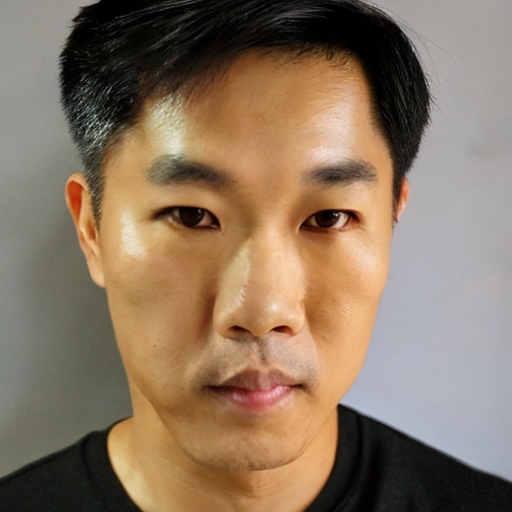

In [334]:
try:
    generated_image = generate_image(image_path=image, mask_path=mask, prompt=prompt,
                                     negative_prompt=negative_prompt, pipe=sd_pipe, seed=seed)
except TypeError as e:
    print(f"TypeError : {e}")

generated_image